In [39]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from shapely.geometry import Point
import copy
import time
import bisect

In [91]:
# TO DO
# Alter packing metric: Probably need to define something else which will penalise "holes"
# Weight neighbour metric by (normalised) border length

In [153]:
geodata = gpd.read_file('./Data/LADs.geojson').to_crs('epsg:27700')
# geodata = geodata[['E09' in c for c in geodata['LAD20CD']]][['LAD20CD', 'LAD20NM', 'geometry']]
geodata = geodata[['W' in c for c in geodata['LAD20CD']]][['LAD20CD', 'LAD20NM', 'geometry']]
geodata['dummy'] = geodata['geometry'].apply(lambda g: 1)

In [154]:
geodata['centroid'] = geodata.centroid

In [155]:
geodata

,LAD20CD,LAD20NM,geometry,dummy,centroid
357,W06000001,Isle of Anglesey,"POLYGON ((240000.004 394577.908, 240445.514 39...",1,POINT (241835.228 379233.676)
358,W06000002,Gwynedd,"MULTIPOLYGON (((267978.708 372366.304, 270868....",1,POINT (264136.399 334667.737)
359,W06000003,Conwy,"POLYGON ((299724.870 380889.607, 300371.113 37...",1,POINT (284072.324 361552.108)
360,W06000004,Denbighshire,"POLYGON ((324414.214 353387.707, 323145.711 35...",1,POINT (309507.880 355562.623)
361,W06000005,Flintshire,"MULTIPOLYGON (((313293.515 382786.601, 315287....",1,POINT (322547.437 368615.133)
362,W06000006,Wrexham,"POLYGON ((351298.712 343127.004, 350716.010 34...",1,POINT (331695.185 344175.768)
363,W06000008,Ceredigion,"POLYGON ((279749.210 249226.602, 277768.013 24...",1,POINT (258559.569 263733.729)
364,W06000009,Pembrokeshire,"MULTIPOLYGON (((216364.016 243983.404, 217396....",1,POINT (201337.424 221180.436)
365,W06000010,Carmarthenshire,"POLYGON ((279749.210 249226.602, 282307.116 24...",1,POINT (251556.904 225139.754)
366,W06000011,Swansea,"MULTIPOLYGON (((262123.115 210278.302, 264479....",1,POINT (258170.595 195828.191)


<AxesSubplot:>

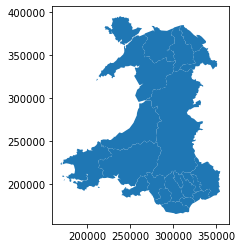

In [156]:
geodata.plot()

In [157]:
g_copygeo = copy.copy(geodata)
g_copygeo['geocopy'] = g_copygeo.geometry
neighbours = g_copygeo.sjoin(g_copygeo, how='inner', predicate='touches')
neighbours = neighbours.loc[neighbours['LAD20CD_left']!=neighbours['LAD20CD_right']]
neighbours['intersection'] = neighbours.apply(lambda row: row['geocopy_left'].intersection(row['geocopy_right']), axis=1)
neighbours['weight'] = neighbours.apply(lambda row: row['intersection'].length/row['geocopy_left'].length, axis=1)

neighbours = neighbours[['LAD20CD_left', 'LAD20CD_right', 'weight']]

/home/tpeterken/anaconda3/envs/AutoCartogram/lib/python3.10/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/home/tpeterken/anaconda3/envs/AutoCartogram/lib/python3.10/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/home/tpeterken/anaconda3/envs/AutoCartogram/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  numbe

In [158]:
neighbours

,LAD20CD_left,LAD20CD_right,weight
358,W06000002,W06000004,0.042755
359,W06000003,W06000004,0.300156
361,W06000005,W06000004,0.395938
362,W06000006,W06000004,0.268325
377,W06000023,W06000004,0.017204
...,...,...,...
377,W06000023,W06000019,0.026017
373,W06000019,W06000021,0.074281
374,W06000020,W06000021,0.468389
376,W06000022,W06000021,0.314966


In [159]:
crossjoin = geodata.merge(geodata, how='inner', on='dummy', suffixes=('_left', '_right'))
crossjoin = crossjoin.loc[crossjoin['LAD20CD_left']!=crossjoin['LAD20CD_right']]
crossjoin['distance'] = crossjoin.apply(lambda row: row['geometry_left'].distance(row['geometry_right']), axis=1)
crossjoin['target_distance_rank'] = crossjoin.groupby('LAD20CD_left')['distance'].rank()
crossjoin['target_angle'] = crossjoin.apply(lambda row: angle_between(row['centroid_left'], row['centroid_right']), axis=1)
distance_ranking = crossjoin[['LAD20CD_left', 'LAD20CD_right', 'target_distance_rank', 'target_angle']]

In [160]:
distance_ranking

,LAD20CD_left,LAD20CD_right,target_distance_rank,target_angle
1,W06000001,W06000002,1.0,-1.106822
2,W06000001,W06000003,2.0,-0.396460
3,W06000001,W06000004,3.0,-0.336486
4,W06000001,W06000005,4.0,-0.130809
5,W06000001,W06000006,6.0,-0.371977
...,...,...,...,...
478,W06000024,W06000019,4.0,0.220886
479,W06000024,W06000020,7.0,-0.237013
480,W06000024,W06000021,9.0,0.065829
481,W06000024,W06000022,10.0,-0.597980


In [223]:
# orientation_ranking = geodata.join(geodata.bounds)

# ix_list = orientation_ranking.index
# minxlist = orientation_ranking['minx']
# maxxlist = orientation_ranking['maxx']
# minylist = orientation_ranking['miny']
# maxylist = orientation_ranking['maxy']

# def get_orient_position(index, loc, loclist):
#     ixlist_to_use = [i for i in ix_list if i != index]
#     loclist_to_use = np.sort(loclist[ixlist_to_use])
#     return bisect.bisect(loclist_to_use, loc)    

# orientation_ranking['x'] = orientation_ranking['centroid'].apply(lambda c: c.xy[0][0])
# orientation_ranking['y'] = orientation_ranking['centroid'].apply(lambda c: c.xy[1][0])

# orientation_ranking['EW_lo'] = orientation_ranking.apply(lambda row: get_orient_position(row.name, row['minx'], minxlist), axis=1)
# orientation_ranking['EW_hi'] = orientation_ranking.apply(lambda row: get_orient_position(row.name, row['maxx'], maxxlist), axis=1)
# orientation_ranking['NS_lo'] = orientation_ranking.apply(lambda row: get_orient_position(row.name, row['miny'], minylist), axis=1)
# orientation_ranking['NS_hi'] = orientation_ranking.apply(lambda row: get_orient_position(row.name, row['maxy'], maxylist), axis=1)

# orientation_ranking['EW'] = orientation_ranking.apply(lambda row: np.sort([row['EW_lo'], row['EW_hi']]), axis=1)
# orientation_ranking['NS'] = orientation_ranking.apply(lambda row: np.sort([row['NS_lo'], row['NS_hi']]), axis=1)

# orientation_ranking = orientation_ranking[['LAD20CD', 'EW', 'NS']]

In [224]:
orientation_ranking = copy.copy(geodata)[['LAD20CD', 'centroid']]
orientation_ranking['x'] = orientation_ranking['centroid'].apply(lambda c: c.xy[0][0])
orientation_ranking['y'] = orientation_ranking['centroid'].apply(lambda c: c.xy[1][0])
orientation_ranking['EW'] = orientation_ranking['x'].rank()
orientation_ranking['NS'] = orientation_ranking['y'].rank()
orientation_ranking = orientation_ranking[['LAD20CD', 'EW', 'NS']]

In [225]:
orientation_ranking

,LAD20CD,EW,NS
357,W06000001,2.0,22.0
358,W06000002,6.0,17.0
359,W06000003,8.0,20.0
360,W06000004,14.0,19.0
361,W06000005,18.0,21.0
362,W06000006,20.0,18.0
363,W06000008,5.0,15.0
364,W06000009,1.0,13.0
365,W06000010,3.0,14.0
366,W06000011,4.0,7.0


In [226]:
# Create an initial grid

scale_factor = 0
sfs = [scale_factor]
# scale_factor_interval = len(geodata)/200
scale_factor_interval = 0.1

initial_grid_size = -1
gss = [initial_grid_size]
full_bounds = geodata.total_bounds
axis_ratio = (full_bounds[3]-full_bounds[1])/(full_bounds[2]-full_bounds[0])

while initial_grid_size < len(geodata):

    scale_factor += scale_factor_interval
    
    initial_y_length = int(np.round(scale_factor*np.sqrt(len(geodata)/axis_ratio), decimals=0))
    initial_x_length = int(np.round(axis_ratio*initial_y_length))

    initial_grid = np.meshgrid(range(initial_x_length), range(initial_x_length))
    initial_grid_size = initial_y_length*initial_x_length
    
    sfs.append(scale_factor)
    gss.append(initial_grid_size)

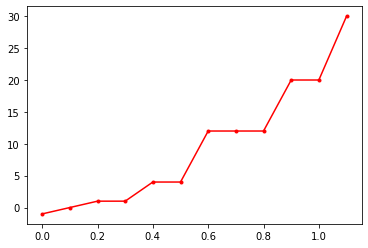

In [227]:
plt.plot(sfs, gss, 'r.-')

In [228]:
neighbour_distance_factor = 8
# neighbour_angle_factor = 0

proximity_distance_factor = 0
# proximity_angle_factor = 0

packing_factor = 1

orientation_factor = 70

max_move_jump = 1


def generate_geodataframe(codes, coords):
    
    grid_pdf = pd.DataFrame({
        'code': codes,
        'y': coords[0],
        'x': coords[1]
    })
    grid_gdf = gpd.GeoDataFrame(grid_pdf, geometry=gpd.points_from_xy(grid_pdf['x'], grid_pdf['y']))
    grid_gdf.crs = 'epsg:27700'
    
    return grid_gdf[['code', 'geometry']]


def angle_difference(angle1, angle2):
    d = angle2-angle1
    d = d+(2*np.pi) if d < -np.pi else d
    d = d-(2*np.pi) if d > np.pi else d
    return d


def neighbour_metric(it_gdf):
    
     # Find the distances and angles to all the neighbours
    it_neighbours = it_gdf.merge(neighbours, left_on='code', right_on='LAD20CD_left')
    it_neighbours = it_neighbours.merge(it_gdf, left_on='LAD20CD_right', right_on='code', suffixes=('', '_r'))
    it_neighbours = it_neighbours[['code', 'geometry', 'code_r', 'geometry_r', 'weight']]

    it_neighbours['distance'] = it_neighbours.apply(lambda row: row['geometry'].distance(row['geometry_r']), axis=1)
#     it_neighbours['distance'] = it_neighbours['distance'].apply(lambda d: 0 if d==1 else (0.5 if d < 1.5 else d))
    it_neighbours['distance'] = it_neighbours['distance'].apply(lambda d: 0 if d<1.5 else d)
#     it_neighbours['angle'] = it_neighbours.apply(lambda row: angle_between(row['geometry'], row['geometry_r']), axis=1)
#     it_neighbours['angle_diff'] = it_neighbours.apply(lambda row: angle_difference(row['angle'], row['target_angle']), axis=1)

    # Define the neighbour metric
#     it_neighbours['neighbour_metric'] = it_neighbours.apply(lambda row: (neighbour_distance_factor*row['distance']**2)+(neighbour_angle_factor*row['angle_diff']**2), axis=1)
    it_neighbours['neighbour_metric'] = it_neighbours.apply(lambda row: neighbour_distance_factor*(row['weight']*row['distance'])**2, axis=1)
    neighbour_metric = it_neighbours.groupby('code')['neighbour_metric'].sum().reset_index()
#     it_gdf = it_gdf.merge(neighbour_metric, on='code', how='left').fillna(0)
    
    return neighbour_metric


def proximity_metric(it_gdf):
    
    # Define the proximity metric
    it_prox = it_gdf.merge(distance_ranking, left_on='code', right_on='LAD20CD_left')
    it_prox = it_prox.merge(it_gdf, left_on='LAD20CD_right', right_on='code', suffixes=('', '_r'))
    it_prox = it_prox[['code', 'geometry', 'code_r', 'geometry_r', 'target_distance_rank', 'target_angle']]
    
    it_prox['distance'] = it_prox.apply(lambda row: row['geometry'].distance(row['geometry_r']), axis=1)
    it_prox['distance_rank'] = it_prox.groupby('code')['distance'].rank()
    it_prox['distance_rank_difference'] = it_prox['distance_rank']-it_prox['target_distance_rank']
#     it_prox['angle'] = it_prox.apply(lambda row: angle_between(row['geometry'], row['geometry_r']), axis=1)
#     it_prox['angle_diff'] = it_prox.apply(lambda row: angle_difference(row['angle'], row['target_angle']), axis=1)
    
#     it_prox['proximity_metric'] = it_prox.apply(lambda row: (proximity_distance_factor*row['distance_rank_difference']**2)+(proximity_angle_factor*row['angle_diff']**2), axis=1)
    it_prox['proximity_metric'] = it_prox.apply(lambda row: proximity_distance_factor*row['distance_rank_difference']**2, axis=1)
    proximity_metric = it_prox.groupby('code')['proximity_metric'].sum().reset_index()
#     it_gdf = it_gdf.merge(proximity_metric, on='code', how='left').fillna(0)
    
    return proximity_metric


def packing_metric(it_gdf):
    
    # Define the packing metric
    it_pack = copy.copy(it_gdf)
    it_pack['dummy'] = [1]*len(it_pack)
    it_pack = it_pack.merge(it_pack, how='inner', on='dummy', suffixes=('', '_r'))
    it_pack['distance'] = it_pack.apply(lambda row: row['geometry'].distance(row['geometry_r']), axis=1)
    it_pack['packing_metric'] = it_pack.apply(lambda row: packing_factor*row['distance']**2, axis=1)
    packing_metric = it_pack.groupby('code')['packing_metric'].sum().reset_index()
#     it_gdf = it_gdf.merge(packing_metric, on='code', how='left').fillna(0)
    
    return packing_metric
    
# def _orient_func(row, comp):
#     loc = row[comp+'_current']
#     ref = row[comp]
#     if loc > ref[1]:
#         return loc-ref[1]
#     elif loc < ref[0]:
#         return loc-ref[0]
#     else:
#         return 0
    
# def orientation_metric(it_gdf):
#     it_orient = copy.copy(it_gdf)
#     it_orient['x'] = it_orient['geometry'].apply(lambda g: g.xy[0][0])
#     it_orient['y'] = it_orient['geometry'].apply(lambda g: g.xy[1][0])
#     it_orient['EW_current'] = it_orient['x'].rank()
#     it_orient['NS_current'] = it_orient['y'].rank()
    
#     it_orient = it_orient.merge(orientation_ranking, left_on='code', right_on='LAD20CD', how='left')
#     it_orient['orientation_metric'] = it_orient.apply(lambda row: orientation_factor*(_orient_func(row, "EW")**2 + _orient_func(row, "NS")**2), axis=1)
    
#     return it_orient[['code', 'orientation_metric']]

def orientation_metric(it_gdf):
    # Define the orientation metric
    it_orient = copy.copy(it_gdf)
    it_orient['x'] = it_orient['geometry'].apply(lambda g: g.xy[0][0])
    it_orient['y'] = it_orient['geometry'].apply(lambda g: g.xy[1][0])
    it_orient['EW_current'] = it_orient['x'].rank()
    it_orient['NS_current'] = it_orient['y'].rank()
    it_orient = it_orient.merge(orientation_ranking, left_on='code', right_on='LAD20CD', how='left')
    it_orient['orientation_metric'] = it_orient.apply(lambda row: orientation_factor*((row['EW_current']-row['EW'])**2 + (row['NS_current']-row['NS'])**2), axis=1)
#     it_gdf = it_gdf.merge(it_orient[['code', 'orientation_metric']], on='code', how='left')    
    
    return it_orient[['code', 'orientation_metric']]
    

def get_metric(it_gdf):

    it_gdf = (
        it_gdf
        .merge(neighbour_metric(it_gdf), on='code', how='left')
        .merge(proximity_metric(it_gdf), on='code', how='left')
        .merge(packing_metric(it_gdf), on='code', how='left')
        .merge(orientation_metric(it_gdf), on='code', how='left')
        .fillna(0)
    )
    
    it_gdf['metric'] = it_gdf['neighbour_metric']+it_gdf['proximity_metric']+it_gdf['packing_metric']+it_gdf['orientation_metric']
    return it_gdf


def find_it_gdf(codes_list, coords):
    it_gdf = generate_geodataframe(codes_list, coords)
    return get_metric(it_gdf)

def single_swap(gdf, from_loc, to_loc):
    new_df = copy.copy(gdf)
    new_df.loc[(gdf['geometry']==to_loc), 'geometry'] = from_loc
    new_df.loc[(gdf['geometry']==from_loc), 'geometry'] = to_loc

    metric_columns = [c for c in new_df.columns if 'metric' in c]
    new_df = get_metric(new_df.drop(columns=metric_columns))
    return new_df
    

def do_swaps(gdf, max_metric):
    
    original_metric = gdf['metric'].sum()
    original_loc = max_metric['geometry'].values[0]
    original_x, original_y = original_loc.xy
    
    directions = []
    metrics = []
    new_dfs = []
    
    for x_shift in range(-max_move_jump, max_move_jump+1):
        for y_shift in range(-max_move_jump, max_move_jump+1):
            
            if (x_shift,y_shift)==(0,0):
                new_df = copy.copy(gdf)
            else:
                new_loc = Point((original_x[0]+x_shift, original_y[0]+y_shift))
                new_df = single_swap(gdf, original_loc, new_loc)
                            
            directions.append((x_shift, y_shift))
            new_dfs.append(new_df)
            metrics.append(new_df['metric'].sum())

    dir_to_use = directions[np.argmin(metrics)] if np.min(metrics) < original_metric else (0,0)
    output_df = new_dfs[np.argmin(metrics)] if np.min(metrics) < original_metric else gdf
    return dir_to_use, new_dfs[np.argmin(metrics)]


def do_random_move(gdf_in):
    
    bounds = gdf_in.total_bounds
    
    P1 = np.random.choice(gdf_in['geometry'])
    
    x2 = np.random.randint(bounds[0]-max_move_jump, bounds[2]+max_move_jump)
    y2 = np.random.randint(bounds[1]-max_move_jump, bounds[3]+max_move_jump)    
    P2 = Point(x2, y2)
    
    gdf_out = single_swap(gdf_in, P1, P2)
    return gdf_out
    
    


def do_iteration(gdf_in):
        
    gdf = copy.copy(gdf_in)
    gdf['is_tested'] = [False]*len(gdf)
    
    all_tested = False    
    iterate = True
    
    old_gdf = copy.copy(gdf)
    while iterate:    
        max_metric = old_gdf.loc[(old_gdf['is_tested']==False), 'metric'].max()
        row_to_test = old_gdf.loc[(old_gdf['metric']==max_metric) & (old_gdf['is_tested']==False)]
        d, new_gdf = do_swaps(old_gdf, row_to_test)        
        
        if d != (0,0):
            iterate = False
            
        else:
            new_gdf.loc[(new_gdf['metric']==max_metric) & (new_gdf['is_tested']==False), 'is_tested'] = True
            num_tested = new_gdf['is_tested'].sum()
            all_tested = True if num_tested == len(new_gdf) else False
            iterate = True if num_tested < len(new_gdf) else False
            old_gdf = copy.copy(new_gdf)
            
    
    
    return all_tested, new_gdf.drop(columns=['is_tested'])

In [229]:
# Randomly allocate codes to grid locations
codes_list = geodata['LAD20CD'].values

# num_initialisations = len(geodata)
num_initialisations = 20
initial_dfs = {}
initial_metrics = []
for random_seed in range(num_initialisations):
    initial_coords = np.unravel_index(random.sample(range(initial_grid_size), len(codes_list)), (initial_x_length, initial_y_length))
    initial_dfs[random_seed] = find_it_gdf(codes_list, initial_coords)
    initial_metrics.append(initial_dfs[random_seed]['metric'].sum())
    
initial_df = initial_dfs[np.argmin(initial_metrics)]

# initial_layout = np.zeros((initial_x_length, initial_y_length), dtype=object)

# for code,x,y in zip(codes_list,initial_coords[0],initial_coords[1]):
#     initial_layout[x,y] = code

In [230]:
new_df = initial_df

max_consecutive_bad_moves = 30
consecutive_bad_moves = 0
r = 0

while consecutive_bad_moves < max_consecutive_bad_moves:
    met_old = new_df['metric'].sum()
    t_df = do_random_move(new_df)
    met_new = t_df['metric'].sum()
    
    print('rand '+str(r)+': '+str(met_new-met_old))
    
    if met_new < met_old:
        new_df = t_df
        consecutive_bad_moves = 0
    else:
        consecutive_bad_moves += 1
    r+=1
    

rand 0: -13043.515517016902
rand 1: -1189.943896251556
rand 2: 15543.866950211232
rand 3: -9679.838270815526
rand 4: 11342.491159403144
rand 5: 3905.2938381761196
rand 6: 21820.767780505877
rand 7: -5268.056987033153
rand 8: 24272.860294822938
rand 9: 28563.858734572146
rand 10: 58463.4592962686
rand 11: 858.4792053863493
rand 12: -11890.011920550955
rand 13: 3137.2525212801556
rand 14: 30776.70362998928
rand 15: -1449.4768691038626
rand 16: 14822.49004605021
rand 17: 27034.99999999997
rand 18: -13247.525905721166
rand 19: 591.0242718759546
rand 20: 19892.849499259057
rand 21: 10392.227318548234
rand 22: 12021.699853475118
rand 23: 20179.050504212064
rand 24: 5402.332708029717
rand 25: 20363.714626278816
rand 26: 1978.27610591962
rand 27: 22150.117026981592
rand 28: 12189.942223457008
rand 29: 4432.432709136599
rand 30: 12189.942223457008
rand 31: 335.77731179799594
rand 32: 6305.787064643431
rand 33: 6817.2012377998035
rand 34: 14386.070278552157
rand 35: -256.8941403544013
rand 36: 4

In [231]:
c = 'y'
# new_df = initial_df
it = 0

start_time = time.time()

while c == 'y':
    
    ti = time.time()
    
#     f, ax = plt.subplots(figsize=(5,5))
#     ax.axis('off')
    
    old_df = new_df
    met_old = old_df['metric'].sum()
    
    d, new_df = do_iteration(old_df)
    
#     new_df.plot(ax=ax, column='metric')
#     for x, y, label in zip(new_df.geometry.x, new_df.geometry.y, new_df.code):
#         ax.annotate(label[-2:], xy=(x, y), xytext=(0,0), textcoords="offset points")
#     plt.show()  
    
    met_new = new_df['metric'].sum()
    
    c = 'y' if d == False else 'n'
    c = 'n' if met_new > met_old else c
    
    tf = time.time()
    
    print("it "+str(it)+":  "+str(np.round(tf-ti, decimals=1))+' -- '+str(met_new-met_old))
    it+=1
    
#     f.clf()
    
    
total_time = time.time()-start_time
print('TOTAL TIME: '+str(np.round(total_time/60, decimals=1))+' minutes')

it 0:  1.8 -- -3311.124325370489
it 1:  1.5 -- -3710.1314233190824
it 2:  1.9 -- -2944.2328361858636
it 3:  2.0 -- -2932.950404889136
it 4:  2.0 -- -1962.8765543079498
it 5:  3.0 -- -1477.0116602191774
it 6:  3.2 -- -844.3825019187025
it 7:  2.0 -- -1503.1661735827292
it 8:  1.6 -- -1460.824255768881
it 9:  1.8 -- -1189.628175979793
it 10:  1.6 -- -782.805725129605
it 11:  3.5 -- -348.26287093653445
it 12:  5.8 -- -161.13562627825377
it 13:  3.3 -- -35.979767426482795
it 14:  7.6 -- -438.9931658306177
it 15:  3.9 -- -420.58399809426373
it 16:  6.6 -- -99.44001003778612
it 17:  5.4 -- -248.28532267009905
it 18:  6.5 -- -175.94422467266668
it 19:  11.7 -- -523.8482021620584
it 20:  1.4 -- -40.0
it 21:  11.2 -- -80.45644771628213
it 22:  3.7 -- -601.2991746630923
it 23:  9.4 -- -151.8965650529608
it 24:  8.4 -- -79.0
it 25:  7.7 -- -274.1524893699443
it 26:  1.4 -- -52.0
it 27:  8.7 -- -368.8466612793545
it 28:  5.5 -- -352.4680288606305
it 29:  10.1 -- -72.76919711267328
it 30:  26.1 -- 

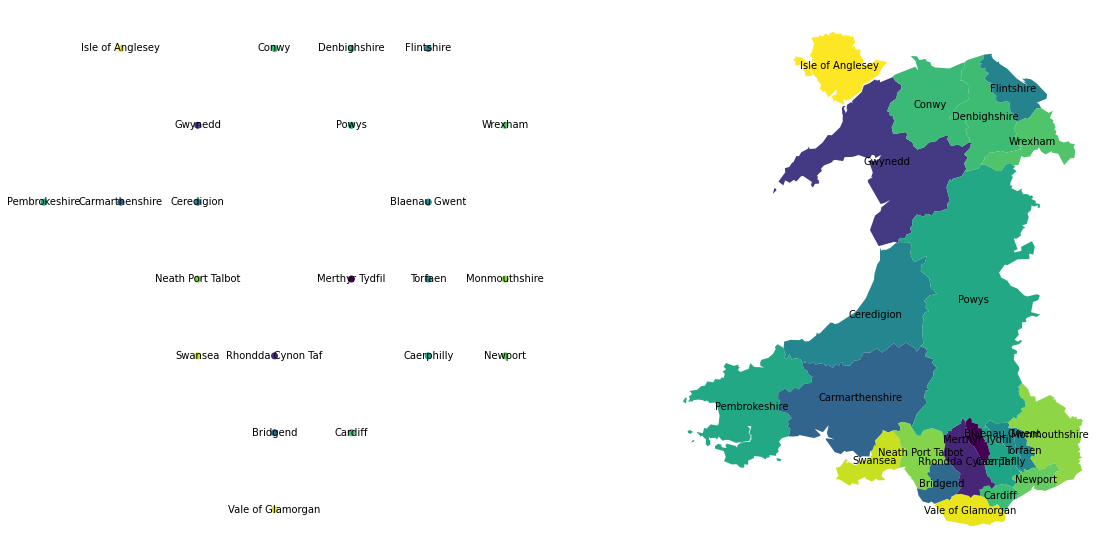

In [232]:
f, axs = plt.subplots(ncols=2, figsize=(20,10))
[ax.axis('off') for ax in axs]

final = new_df[['code', 'geometry', 'metric']].merge(geodata[['LAD20NM', 'LAD20CD']], left_on='code', right_on='LAD20CD')

final.plot(column='metric', ax=axs[0])

for x, y, label in zip(final.geometry.x, final.geometry.y, final.LAD20NM):
    axs[0].annotate(label, xy=(x, y), xytext=(0,0), textcoords="offset points", ha='center', va='center')
    
    
original = geodata[['LAD20CD', 'LAD20NM', 'geometry', 'centroid']].merge(new_df[['code', 'metric']], left_on='LAD20CD', right_on='code')
original.plot(column='metric', ax=axs[1])

for x, y, label in zip(original.centroid.x, original.centroid.y, original.LAD20NM):
    axs[1].annotate(label, xy=(x,y), xytext=(0,0), textcoords="offset points", ha='center', va='center')